
====== Logistic Regression ======
Accuracy: 0.9574
F1 Score: 0.9567
Classification Report:
               precision    recall  f1-score   support

        Good       0.97      0.98      0.98       328
    Moderate       0.82      0.77      0.80        43
        Poor       0.96      0.93      0.95        28

    accuracy                           0.96       399
   macro avg       0.92      0.89      0.91       399
weighted avg       0.96      0.96      0.96       399

Confusion Matrix:
 [[323   5   0]
 [  9  33   1]
 [  0   2  26]]

====== Decision Tree ======
Accuracy: 0.9749
F1 Score: 0.975
Classification Report:
               precision    recall  f1-score   support

        Good       0.99      0.99      0.99       328
    Moderate       0.88      0.88      0.88        43
        Poor       0.93      0.96      0.95        28

    accuracy                           0.97       399
   macro avg       0.94      0.95      0.94       399
weighted avg       0.98      0.97      0.97      

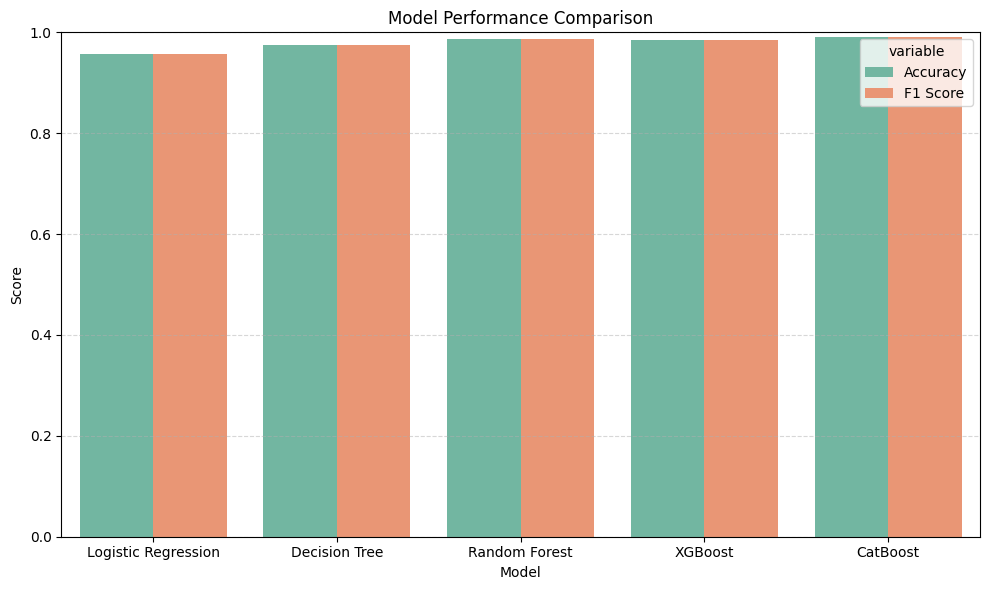

In [2]:
# Install Required Libraries (if not already installed)
!pip install xgboost catboost --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")

# Step 1: Load & Prepare Dataset
df = pd.read_csv('/content/water_dataX.csv', encoding='latin-1')

# Rename columns for consistency
df.rename(columns={
    'Temp': 'Temperature',
    'D.O. (mg/l)': 'DO',
    'PH': 'PH',
    'CONDUCTIVITY (µmhos/cm)': 'Conductivity',
    'B.O.D. (mg/l)': 'BOD',
    'NITRATENAN N+ NITRITENANN (mg/l)': 'Nitrate',
    'FECAL COLIFORM (MPN/100ml)': 'Fecal_Coliform',
    'TOTAL COLIFORM (MPN/100ml)Mean': 'Total_Coliform'
}, inplace=True)

# Convert to numeric and impute missing values
cols = ['Temperature', 'DO', 'PH', 'Conductivity', 'BOD', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df[cols] = df[cols].fillna(df[cols].mean())

# Step 2: Calculate WQI and Label Classes
df['DO_si'] = df['DO'] * (100 / 7.0)
df['PH_si'] = df['PH'] * (100 / 7.0)
df['BOD_si'] = 100 - (df['BOD'] * 5)

df['DO_si'] = df['DO_si'].clip(0, 100)
df['PH_si'] = df['PH_si'].clip(0, 100)
df['BOD_si'] = df['BOD_si'].clip(0, 100)

df['WQI'] = (df['DO_si'] * 0.3) + (df['PH_si'] * 0.2) + (df['BOD_si'] * 0.5)

def label_wqi(wqi):
    if wqi >= 80:
        return 'Good'
    elif wqi >= 50:
        return 'Moderate'
    else:
        return 'Poor'

df['WQI_Label'] = df['WQI'].apply(label_wqi)

# Encode class labels
label_map = {'Good': 0, 'Moderate': 1, 'Poor': 2}
df['WQI_Encoded'] = df['WQI_Label'].map(label_map)

# Step 3: Prepare Features and Target
X = df[cols]
y = df['WQI_Encoded']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Stratified split (preserves class proportions)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Train & Evaluate Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'CatBoost': CatBoostClassifier(verbose=0)
}

results = []
target_names = ['Good', 'Moderate', 'Poor']

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    cm = confusion_matrix(y_test, preds)

    print(f"\n====== {name} ======")
    print("Accuracy:", round(acc, 4))
    print("F1 Score:", round(f1, 4))
    print("Classification Report:\n", classification_report(y_test, preds, target_names=target_names))
    print("Confusion Matrix:\n", cm)

    results.append((name, acc, f1))

# Step 5: Plot Model Comparison
perf_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Score'])
plt.figure(figsize=(10, 6))
sns.barplot(data=perf_df.melt(id_vars='Model'), x='Model', y='value', hue='variable', palette='Set2')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

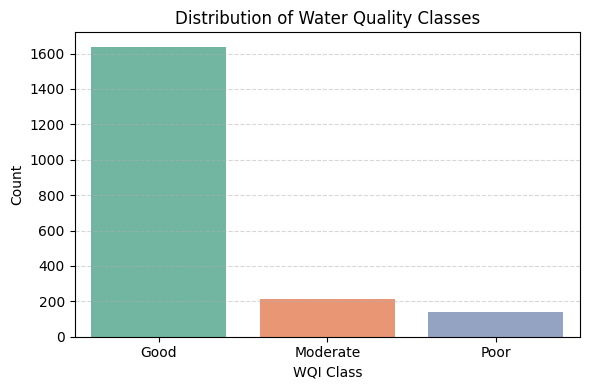

In [3]:
# Visualize WQI Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='WQI_Label', data=df, order=['Good', 'Moderate', 'Poor'], palette='Set2')
plt.title('Distribution of Water Quality Classes')
plt.xlabel('WQI Class')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

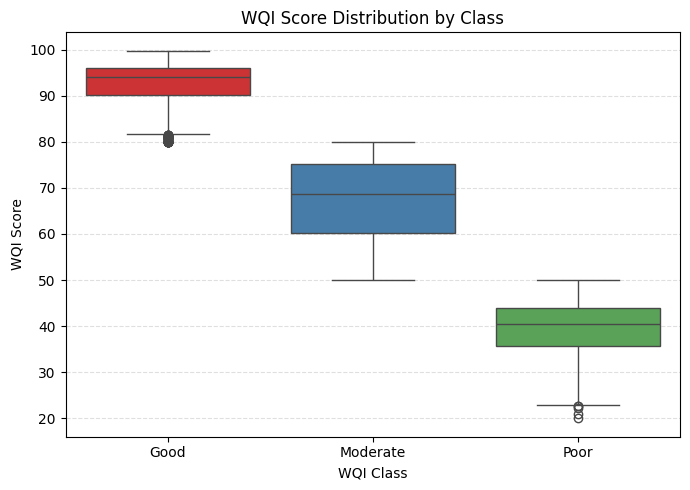

In [4]:
# Box Plot of WQI by Class
plt.figure(figsize=(7, 5))
sns.boxplot(x='WQI_Label', y='WQI', data=df, palette='Set1', order=['Good', 'Moderate', 'Poor'])
plt.title('WQI Score Distribution by Class')
plt.xlabel('WQI Class')
plt.ylabel('WQI Score')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()